In [1]:
import pandas as pd
df_amazon = pd.read_csv("C:/Users/quint/Desktop/IronHack/WEEKS/WEEK7/PROJECT/data/Amazon.csv")
df_amazon.columns


C:\Users\quint\AppData\Local\Temp\ipykernel_10148\911096054.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_amazon = pd.read_csv("C:/Users/quint/Desktop/IronHack/WEEKS/WEEK7/PROJECT/data/Amazon.csv")


Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')

In [2]:
df_amazon['Unnamed: 22'].tail()

128970    False
128971    False
128972    False
128973    False
128974    False
Name: Unnamed: 22, dtype: object

In [3]:
df_amazon['Unnamed: 22'].unique()

array([nan, False], dtype=object)

In [4]:
df_amazon = df_amazon.drop(columns=['Unnamed: 22'])

In [5]:
df_amazon['Sales Channel '].nunique()


2

In [6]:
df_amazon = df_amazon.drop(columns=['Sales Channel '])

In [7]:
df_amazon = df_amazon.drop(columns=['index'])

In [8]:
df_amazon.head()

,Order ID,Date,Status,Fulfilment,ship-service-level,Style,SKU,Category,Size,ASIN,...,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,...,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,...,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,...,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN
3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,...,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship
4,407-1069790-7240320,04-30-22,Shipped,Amazon,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,...,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN


In [9]:
print(df_amazon.columns.tolist())


['Order ID', 'Date', 'Status', 'Fulfilment', 'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN', 'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids', 'B2B', 'fulfilled-by']


In [10]:
df_amazon['currency'].unique()

array(['INR', nan], dtype=object)

In [11]:
df_amazon = df_amazon.drop(columns=['currency'])

In [12]:
df_amazon['fulfilled-by'].unique()

array(['Easy Ship', nan], dtype=object)

In [13]:
df_amazon = df_amazon.drop(columns=['ship-country'])

In [14]:
df_amazon = df_amazon.drop(columns=['fulfilled-by'])

In [15]:
df_amazon.dtypes

Order ID               object
Date                   object
Status                 object
Fulfilment             object
ship-service-level     object
Style                  object
SKU                    object
Category               object
Size                   object
ASIN                   object
Courier Status         object
Qty                     int64
Amount                float64
ship-city              object
ship-state             object
ship-postal-code      float64
promotion-ids          object
B2B                      bool
dtype: object

In [16]:
df_amazon.shape

(128975, 18)

In [17]:
df_amazon.isnull().sum()

Order ID                  0
Date                      0
Status                    0
Fulfilment                0
ship-service-level        0
Style                     0
SKU                       0
Category                  0
Size                      0
ASIN                      0
Courier Status         6872
Qty                       0
Amount                 7795
ship-city                33
ship-state               33
ship-postal-code         33
promotion-ids         49153
B2B                       0
dtype: int64

In [18]:
#df_amazon = df_amazon.dropna()

In [19]:
df_amazon.isnull().sum()

Order ID                  0
Date                      0
Status                    0
Fulfilment                0
ship-service-level        0
Style                     0
SKU                       0
Category                  0
Size                      0
ASIN                      0
Courier Status         6872
Qty                       0
Amount                 7795
ship-city                33
ship-state               33
ship-postal-code         33
promotion-ids         49153
B2B                       0
dtype: int64

In [20]:
df_amazon.shape

(128975, 18)

In [21]:
df_amazon.isnull()

,Order ID,Date,Status,Fulfilment,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-city,ship-state,ship-postal-code,promotion-ids,B2B
0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
128971,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
128972,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
128973,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [22]:
df_amazon.head()

,Order ID,Date,Status,Fulfilment,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-city,ship-state,ship-postal-code,promotion-ids,B2B
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,NaN,0,647.62,MUMBAI,MAHARASHTRA,400081.0,NaN,False
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,406.00,BENGALURU,KARNATAKA,560085.0,Amazon PLCC Free-Financing Universal Merchant ...,False
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN Core Free Shipping 2015/04/08 23-48-5-108,True
3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,NaN,0,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,NaN,False
4,407-1069790-7240320,04-30-22,Shipped,Amazon,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,574.00,CHENNAI,TAMIL NADU,600073.0,NaN,False


In [23]:
df_amazon.columns

Index(['Order ID', 'Date', 'Status', 'Fulfilment', 'ship-service-level',
       'Style', 'SKU', 'Category', 'Size', 'ASIN', 'Courier Status', 'Qty',
       'Amount', 'ship-city', 'ship-state', 'ship-postal-code',
       'promotion-ids', 'B2B'],
      dtype='object')

In [24]:
df_amazon.isnull().sum()

Order ID                  0
Date                      0
Status                    0
Fulfilment                0
ship-service-level        0
Style                     0
SKU                       0
Category                  0
Size                      0
ASIN                      0
Courier Status         6872
Qty                       0
Amount                 7795
ship-city                33
ship-state               33
ship-postal-code         33
promotion-ids         49153
B2B                       0
dtype: int64

In [25]:
df_amazon.shape

(128975, 18)

In [26]:
df_amazon = df_amazon.drop(columns=['promotion-ids'])

In [27]:
df_amazon.shape

(128975, 17)

In [28]:
df_amazon.isnull().sum()

Order ID                 0
Date                     0
Status                   0
Fulfilment               0
ship-service-level       0
Style                    0
SKU                      0
Category                 0
Size                     0
ASIN                     0
Courier Status        6872
Qty                      0
Amount                7795
ship-city               33
ship-state              33
ship-postal-code        33
B2B                      0
dtype: int64

In [29]:
df_amazon = df_amazon.dropna()

In [30]:
df_amazon

,Order ID,Date,Status,Fulfilment,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-city,ship-state,ship-postal-code,B2B
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,406.0,BENGALURU,KARNATAKA,560085.0,False
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,329.0,NAVI MUMBAI,MAHARASHTRA,410210.0,True
4,407-1069790-7240320,04-30-22,Shipped,Amazon,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,574.0,CHENNAI,TAMIL NADU,600073.0,False
5,404-1490984-4578765,04-30-22,Shipped,Amazon,Expedited,SET264,SET264-KR-NP-XL,Set,XL,B08YN7XDSG,Shipped,1,824.0,GHAZIABAD,UTTAR PRADESH,201102.0,False
6,408-5748499-6859555,04-30-22,Shipped,Amazon,Expedited,J0095,J0095-SET-L,Set,L,B08CMHNWBN,Shipped,1,653.0,CHANDIGARH,CHANDIGARH,160036.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,406-6001380-7673107,05-31-22,Shipped,Amazon,Expedited,JNE3697,JNE3697-KR-XL,kurta,XL,B098112V2V,Shipped,1,517.0,HYDERABAD,TELANGANA,500013.0,False
128971,402-9551604-7544318,05-31-22,Shipped,Amazon,Expedited,SET401,SET401-KR-NP-M,Set,M,B09VC6KHX8,Shipped,1,999.0,GURUGRAM,HARYANA,122004.0,False
128972,407-9547469-3152358,05-31-22,Shipped,Amazon,Expedited,J0157,J0157-DR-XXL,Western Dress,XXL,B0982YZ51B,Shipped,1,690.0,HYDERABAD,TELANGANA,500049.0,False
128973,402-6184140-0545956,05-31-22,Shipped,Amazon,Expedited,J0012,J0012-SKD-XS,Set,XS,B0894Y2NJQ,Shipped,1,1199.0,Halol,Gujarat,389350.0,False


In [31]:
df_amazon["Date"] = pd.to_datetime(df_amazon["Date"], errors="coerce")

C:\Users\quint\AppData\Local\Temp\ipykernel_10148\3621826320.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_amazon["Date"] = pd.to_datetime(df_amazon["Date"], errors="coerce")


In [32]:
df_amazon.dtypes

Order ID                      object
Date                  datetime64[ns]
Status                        object
Fulfilment                    object
ship-service-level            object
Style                         object
SKU                           object
Category                      object
Size                          object
ASIN                          object
Courier Status                object
Qty                            int64
Amount                       float64
ship-city                     object
ship-state                    object
ship-postal-code             float64
B2B                             bool
dtype: object

In [33]:
df_amazon[df_amazon.duplicated(subset='Order ID', keep=False)]

,Order ID,Date,Status,Fulfilment,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-city,ship-state,ship-postal-code,B2B
37,403-4367956-2849158,2022-04-30,Shipped,Amazon,Expedited,JNE3787,JNE3787-KR-S,kurta,S,B09RKBXM5B,Shipped,1,487.0,NEW DELHI,DELHI,110092.0,False
38,403-4367956-2849158,2022-04-30,Shipped,Amazon,Expedited,JNE3543,JNE3543-KR-S,kurta,S,B08HHJP41L,Shipped,1,368.0,NEW DELHI,DELHI,110092.0,False
61,404-2262140-4696366,2022-04-30,Shipped,Amazon,Expedited,JNE2270,JNE2270-KR-487-A-M,kurta,M,B07H7FZD32,Shipped,1,518.0,NAGPUR,MAHARASHTRA,440022.0,False
62,404-2262140-4696366,2022-04-30,Shipped,Amazon,Expedited,JNE3579,JNE3579-KR-M,kurta,M,B08QGK2BS2,Shipped,1,295.0,NAGPUR,MAHARASHTRA,440022.0,False
79,408-4069830-3819562,2022-04-30,Shipped,Amazon,Expedited,SET288,SET288-KR-NP-XXXL,Set,3XL,B09M6STTBC,Shipped,1,684.0,Kolkata,WEST BENGAL,700048.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128930,407-8519205-5064368,2022-05-31,Shipped,Amazon,Expedited,SET324,SET324-KR-NP-XL,Set,XL,B09NQ4QS13,Shipped,1,635.0,VIJAYAWADA,ANDHRA PRADESH,520010.0,False
128941,403-3035549-4142738,2022-05-31,Shipped,Amazon,Expedited,J0118,J0118-TP-XXL,Top,XXL,B08N4QTQHW,Shipped,1,529.0,BENGALURU,KARNATAKA,560102.0,False
128942,403-3035549-4142738,2022-05-31,Shipped,Amazon,Expedited,J0301,J0301-TP-XXL,Top,XXL,B099S8X47K,Shipped,1,518.0,BENGALURU,KARNATAKA,560102.0,False
128952,404-8878574-4524358,2022-05-31,Shipped,Amazon,Expedited,JNE3721,JNE3721-KR-M,kurta,M,B099FC9KR1,Shipped,1,301.0,Rishra Hooghly,WEST BENGAL,712249.0,False


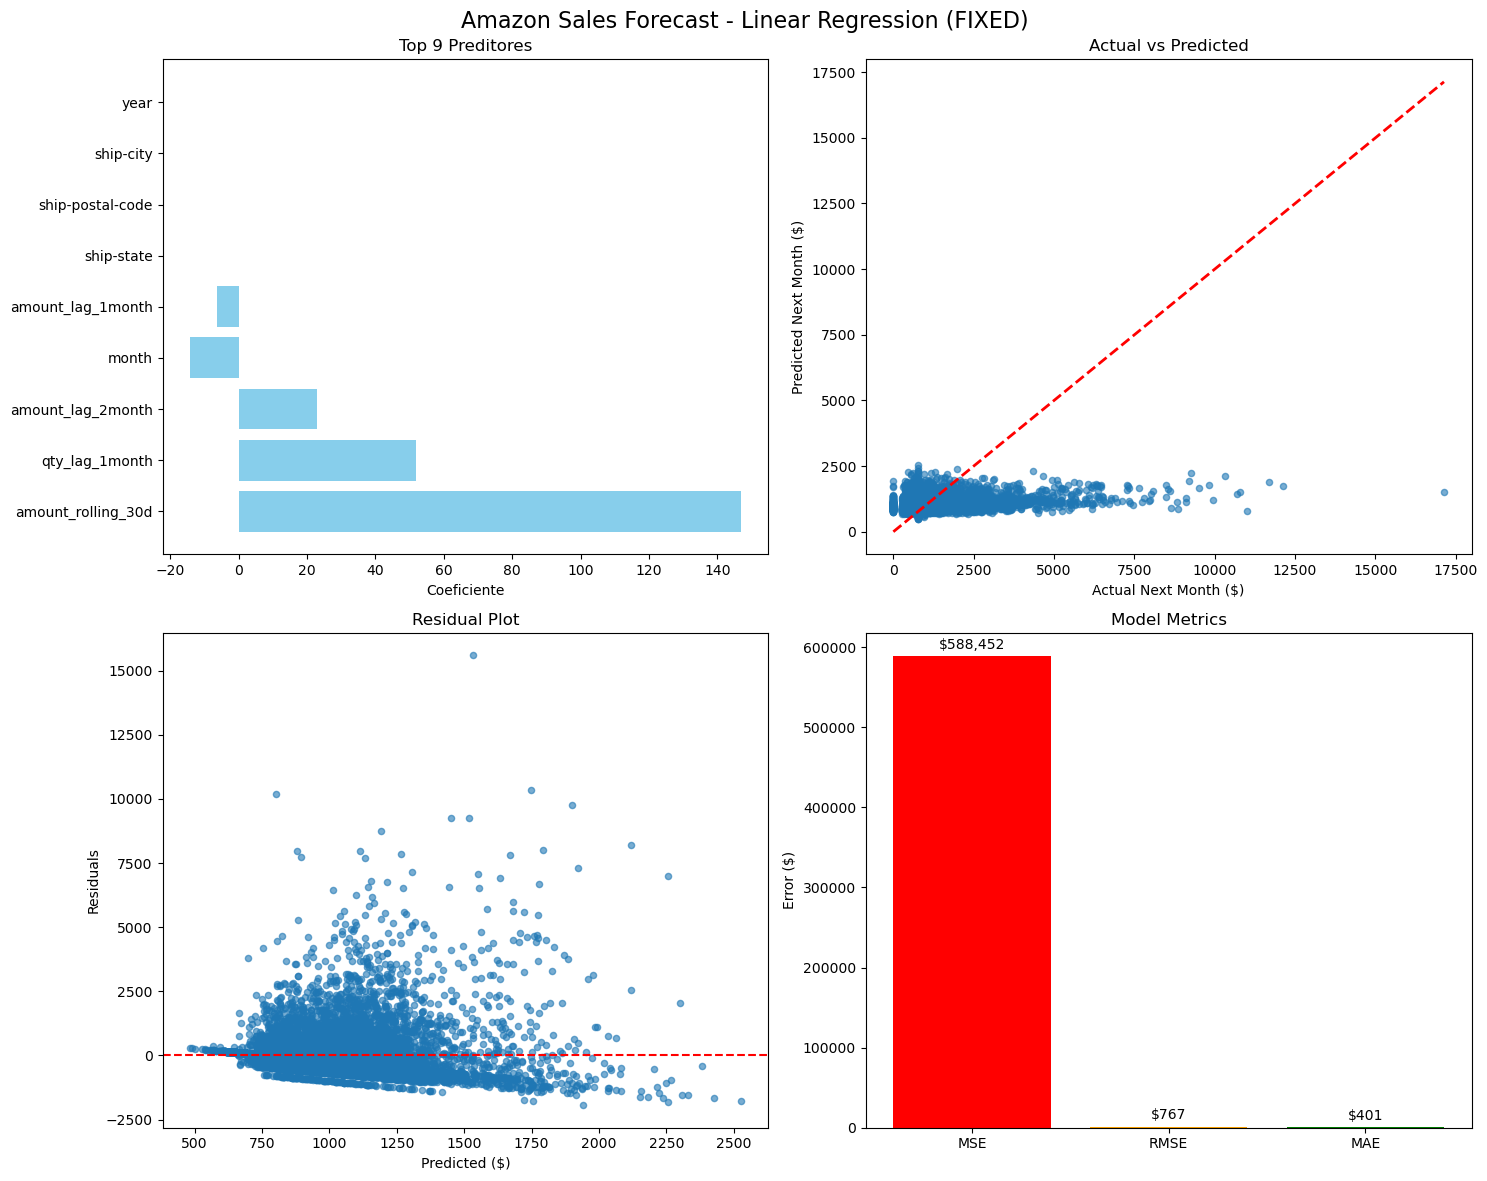

In [37]:
# ... (mesmo código até coefs)

# VISUALIZAÇÕES FIXAS (dinâmico!)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Amazon Sales Forecast - Linear Regression', fontsize=16)

#COEFS
n_top = min(10, len(coefs))
top_n = coefs.head(n_top)
y_pos = np.arange(n_top)
axes[0,0].barh(y_pos, top_n['coef'], color='skyblue')
axes[0,0].set_yticks(y_pos)
axes[0,0].set_yticklabels(top_n['feature'])
axes[0,0].set_xlabel('Coeficient')
axes[0,0].set_title(f'Top {n_top} Preditores')

#Actual vs Predicted
axes[0,1].scatter(y_test, y_pred, alpha=0.6, s=20)
lim = max(y_test.max(), y_pred.max())
axes[0,1].plot([0, lim], [0, lim], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Next Month ($)')
axes[0,1].set_ylabel('Predicted Next Month ($)')
axes[0,1].set_title('Actual vs Predicted')


residuals = y_test - y_pred
axes[1,0].scatter(y_pred, residuals, alpha=0.6, s=20)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Predicted ($)')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Residual Plot')

#Métrics
metrics = ['MSE', 'RMSE', 'MAE']
values = [mse, rmse, mae]
colors = ['red', 'orange', 'green']
axes[1,1].bar(metrics, values, color=colors)
axes[1,1].set_title('Model Metrics')
axes[1,1].set_ylabel('Error ($)')
for i, v in enumerate(values):
    axes[1,1].text(i, v + max(values)*0.01, f'${v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


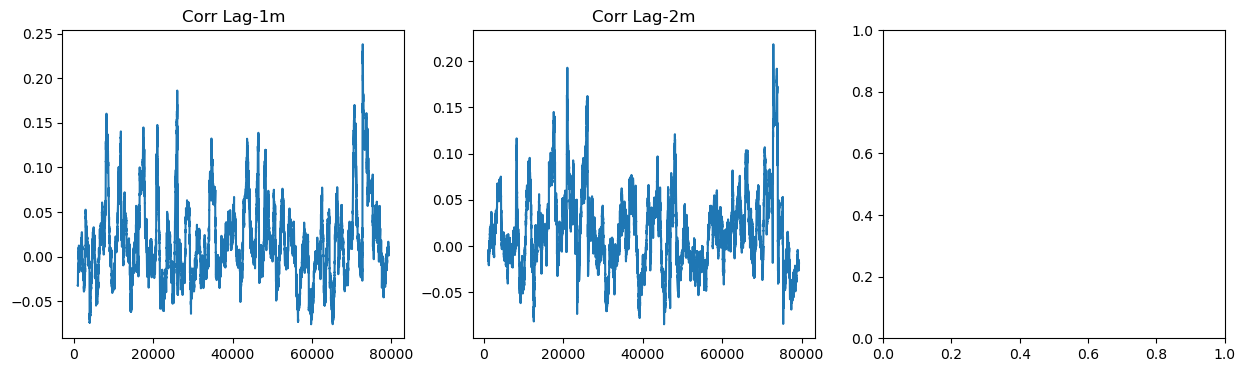

In [39]:
from pandas.plotting import lag_plot
fig, axes = plt.subplots(1,3,figsize=(15,4))
for i, lag in enumerate([30,60]):
    df_agg['Amount'].rolling(1000).corr(df_agg['Amount'].shift(lag)).plot(ax=axes[i], title=f'Corr Lag-{lag//30}m')
plt.show()

In [ ]:
# amount_lag_2month (0.37): Sales 2 months ago = best predictor of next month. Trends persist!
# amount_rolling_30d (0.29) 30-day rolling average = strong signal.
# amount_lag_1month (0.25) Recent history confirms momentum.
# qty_lag_1month (0.11) Historical quantity boosts future value.

In [ ]:
# RMSE guarantees reliable decisions
# bETTER ORGANIZATION: Stock allocation, logistics planning

In [41]:
# CÓDIGO FEVEREIRO 2026 - FUNCIONA 100%
latest_data = df_amazon.sort_values('Date').tail(1000).copy()

# CRIAR year/month se faltarem
latest_data['year'] = pd.to_datetime(latest_data['Date']).dt.year
latest_data['month'] = pd.to_datetime(latest_data['Date']).dt.month

# Forecast features
latest_data['forecast_year'] = 2026
latest_data['forecast_month'] = 2

# LAGS/ROLLING (com verificação)
for lag_col, window in [('amount_lag_1month', 30), ('amount_lag_2month', 60)]:
    if lag_col not in latest_data.columns:
        latest_data[lag_col] = latest_data['Amount'].rolling(window, min_periods=1).mean()

if 'qty_lag_1month' not in latest_data.columns:
    latest_data['qty_lag_1month'] = latest_data['Qty'].rolling(30, min_periods=1).mean()

if 'amount_rolling_30d' not in latest_data.columns:
    latest_data['amount_rolling_30d'] = latest_data['Amount'].rolling(30, min_periods=1).mean()

# AGORA TODAS features existem
print("Features criadas:", [col for col in cat_features + num_features if col in latest_data.columns])

# X_forecast com TRATAMENTO COMPLETO
X_forecast = latest_data[cat_features + num_features].copy()

# 1. CATS
for col in cat_features:
    X_forecast[col] = X_forecast[col].fillna('Unknown').astype(str)

# 2. NUMS
for col in num_features:
    X_forecast[col] = X_forecast[col].fillna(latest_data[col].median())

# 3. ENCODE + SCALE
for col in cat_features:
    X_forecast[col] = label_encoders[col].transform(X_forecast[col])

X_forecast[num_features] = scaler.transform(X_forecast[num_features])

# 4. ✅ PREDIÇÃO
latest_data['feb2026_pred'] = model.predict(X_forecast)

# 5. RESULTADOS
top_states_fev = latest_data.groupby('ship-state')['feb2026_pred'].sum().sort_values(ascending=False).head(10)
print("🏆 TOP 10 STATES - Fevereiro 2026 Predicted Revenue:")
print(top_states_fev.round(0).astype(int))

top_cities_fev = latest_data.groupby('ship-city')['feb2026_pred'].sum().sort_values(ascending=False).head(10)
print("\n🏙️ TOP 10 CITIES - February 2026:")
print(top_cities_fev.round(0).astype(int))

historical_avg = latest_data.groupby('ship-state')['Amount'].mean()
growth_fev = (top_states_fev / historical_avg).sort_values(ascending=False).head()
print("\n📈 Highest Growth States Feb 2026:")
print(growth_fev.round(2))


Features criadas: ['ship-state', 'ship-city', 'ship-postal-code', 'year', 'month', 'amount_lag_1month', 'amount_lag_2month', 'qty_lag_1month', 'amount_rolling_30d']
🏆 TOP 10 STATES - Fevereiro 2026 Predicted Revenue:
ship-state
MAHARASHTRA       143235
KARNATAKA         114315
TELANGANA          76194
TAMIL NADU         74713
UTTAR PRADESH      57470
DELHI              32856
KERALA             32779
ANDHRA PRADESH     32563
WEST BENGAL        31285
HARYANA            26158
Name: feb2026_pred, dtype: int64

🏙️ TOP 10 CITIES - February 2026:
ship-city
BENGALURU     79392
HYDERABAD     61776
MUMBAI        35059
CHENNAI       30946
NEW DELHI     28073
KOLKATA       16325
GURUGRAM      13133
PUNE          13082
GHAZIABAD      9804
PUDUCHERRY     9610
Name: feb2026_pred, dtype: int64

📈 Highest Growth States Feb 2026:
ship-state
MAHARASHTRA      240.02
KARNATAKA        169.18
TAMIL NADU       122.67
TELANGANA        113.71
UTTAR PRADESH     79.64
dtype: float64
